# HW1 - Calcium Imaging Deconvolution

## Part 1) Downloaded Software - OASIS_matlab

### Steps to download the OASIS spike deconvolution software: 

Citation: Friedrich, J., Zhou, P., and Paninski, L., 2016. Fast Active Set Methods for Online Deconvolution of Calcium   Imaging Data  
  
1 - First, download cvx: http://cvxr.com/cvx/download/ (make sure it's the appropriate version for your operating system)  
  This software doesn't quite work yet on MATLAB 2017, so keep that in mind. 
  
1.1 - This download requires a compiler set up in MATLAB, like gcc. If you're not familiar with running compilers  
  then this may be the most difficult step of the process. Google 'supported compilers MATLAB 201x' for your version
  of MATLAB, e.g. 2017 . 
  
2 - Clone the repository on your computer:  
  git clone https://github.com/zhoupc/OASIS_matlab
  
3 - The instructions are quite clear on Github ... Run setup.m and everything should find the proper dependencies. 
  
4 - Add the entire OASIS_matlab folder to the path, e.g.:  
  addpath(genpath('/path/to/oasis/OASIS_matlab/'));
  
5 - Go to OASIS_matlab/examples and run the script test_all.m . This will attempt to run simulated data through all  
  of the algorithms available within the software. The script will print the name of the algorithm and "Success!"  
  after each name. If all algorithms are successful, this confirms that you've done everything correctly.
  
6 - The function deconvolveCa.m is the simplest one to use to actually run data through. See below for examples.  


Everything seems to work well right out of the box ...
  


### Testing the Code

In [1]:
% change directories, download the spikefinder data, and get it into a nicer format

cd('~/Documents/Current-Projects/Nazer_NeuralData/spikefinder.train');

datasets = {'1','2','3','4','5','6','7','8','9','10'};
N = 10;
Fs = 100;

train = 1:5;test = 6:10;

allData = cell(N,2);
numNeurons = zeros(N,1);
for ii=1:10
   calcium_train = csvread([datasets{ii} '.train.calcium.csv']);
   spike_train = csvread([datasets{ii} '.train.spikes.csv']);  
   
   temp = quantile(calcium_train,[0.05,0.8]);

   calcium_train = (calcium_train-temp(1))./(temp(2)-temp(1));
   
   allData{ii,1} = calcium_train;
   allData{ii,2} = spike_train;
   numNeurons(ii) = size(calcium_train,2);
end


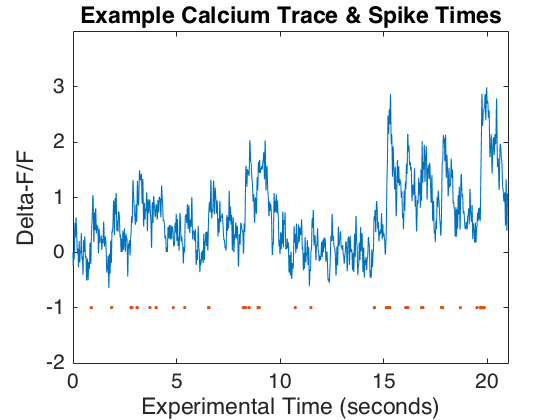

In [5]:
% view one of the traces to see what the data looks like
calcium_train = allData{1,1};spike_train = allData{1,2};
calcium_train = calcium_train(:,1);spike_train = spike_train(:,1);
calcium_train = calcium_train(1:2100);spike_train = spike_train(1:2100);
figure();plot(linspace(0,length(calcium_train)/Fs,length(calcium_train)),calcium_train(:,1));hold on;
title('Example Calcium Trace & Spike Times');
xlabel('Experimental Time (seconds)');ylabel('Delta-F/F')
inds = find(spike_train(:,1));
tempx = linspace(0,length(spike_train)/Fs,length(spike_train));
tempy = -1*ones(length(spike_train),1);
tempx = tempx(inds);
tempy = tempy(inds);
plot(tempx,tempy,'.');
axis([0 length(calcium_train)/Fs -2 max(calcium_train(:,1))+1]);

In [7]:
% change back to the OASIS directory, try the code on training data for several different algorithm types
cd('~/Documents/Current-Projects/OASIS_matlab/');

W = 5;
kernel = ones(W,1)./W;
numAlgorithms = 6;
correlations = zeros(length(train),numAlgorithms);
runningTimes = zeros(length(train),numAlgorithms);
algorithm = cell(numAlgorithms,2);
algorithm{1,1} = 'ar1';algorithm{1,2} = 'foopsi';
algorithm{2,1} = 'ar2';algorithm{2,2} = 'foopsi';
algorithm{3,1} = 'exp2';algorithm{3,2} = 'foopsi';
algorithm{4,1} = 'ar1';algorithm{4,2} = 'constrained';
algorithm{5,1} = 'ar1';algorithm{5,2} = 'thresholded';
algorithm{6,1} = 'ar2';algorithm{6,2} = 'thresholded';
for ii=train
    % gather data for each training dataset
    calcium_train = allData{ii,1};
    spike_train = allData{ii,2};
   
   tempCorr = zeros(numNeurons(ii),numAlgorithms);
   tempTimes = zeros(numNeurons(ii),numAlgorithms);
   for jj=1:numNeurons(ii)
      for kk=1:numAlgorithms
          % this is the main section ... deconvolveCa is the function that runs the code
          tic;
          [~,est_s,~] = deconvolveCa(calcium_train(:,jj),algorithm{kk,1},algorithm{kk,2});
          temp = toc;tempTimes(jj,kk) = temp./length(est_s);
          
          % bin the data, calculate the correlation coefficient between estimated and true spike trains
          est_s = conv(est_s,kernel);
      
          true_s = spike_train(:,jj);
          true_s = conv(true_s,kernel);
          
          [r,~] = corrcoef(true_s,est_s);
          tempCorr(jj,kk) = r(1,2);
      end
   end
   correlations(ii,:) = mean(tempCorr,1);
   runningTimes(ii,:) = mean(tempTimes,1);
end

% by-algorithm overall correlation on all training data
fprintf('Run-time and correlation statistics for training data across algorithms:\n\n');
byalgo_avg_corr = mean(correlations,1);
byalgo_std_corr = std(correlations,[],1);
byalgo_max_corr = max(correlations,[],1);
byalgo_avg_runtime = mean(runningTimes,1);
for ii=1:numAlgorithms
    fprintf('Algorithm: %s %s\n  Mean Per-Bin Run-Time: %3.2e\n  Mean Corr: %3.3f\n  Std Corr: %3.3f\n  Max Corr: %3.3f\n\n',algorithm{ii,1},algorithm{ii,2},byalgo_avg_runtime(ii),byalgo_avg_corr(ii),byalgo_std_corr(ii),byalgo_max_corr(ii));
end

Run-time and correlation statistics for training data across algorithms:

Algorithm: ar1 foopsi
  Mean Per-Bin Run-Time: 1.28e-06
  Mean Corr: 0.283
  Std Corr: 0.040
  Max Corr: 0.326

Algorithm: ar2 foopsi
  Mean Per-Bin Run-Time: 1.26e-05
  Mean Corr: 0.238
  Std Corr: 0.081
  Max Corr: 0.317

Algorithm: exp2 foopsi
  Mean Per-Bin Run-Time: 1.88e-05
  Mean Corr: 0.194
  Std Corr: 0.091
  Max Corr: 0.315

Algorithm: ar1 constrained
  Mean Per-Bin Run-Time: 1.31e-06
  Mean Corr: 0.283
  Std Corr: 0.040
  Max Corr: 0.326

Algorithm: ar1 thresholded
  Mean Per-Bin Run-Time: 1.23e-06
  Mean Corr: 0.283
  Std Corr: 0.040
  Max Corr: 0.326

Algorithm: ar2 thresholded
  Mean Per-Bin Run-Time: 1.26e-05
  Mean Corr: 0.238
  Std Corr: 0.081
  Max Corr: 0.317


For these datasets, it appears that the auto-regressive order 1 model works the best, regardless of the secondary algorithm choice. The FOOPSI model is the convex optimization problem that we discussed in class. It finds the arg-min of 0.5(y-c)^2+lambdaXnorm(s,1), subject to the non-negativity constraint for the estimated spike train, s. You can further optimize these algorithms by running the AIC or cross-validation to determine parameters like lambda for each dataset. I'll skip that step and run the AR1 FOOPSI on the test data.

### Running the AR1, FOOPSI Model on the Test Data

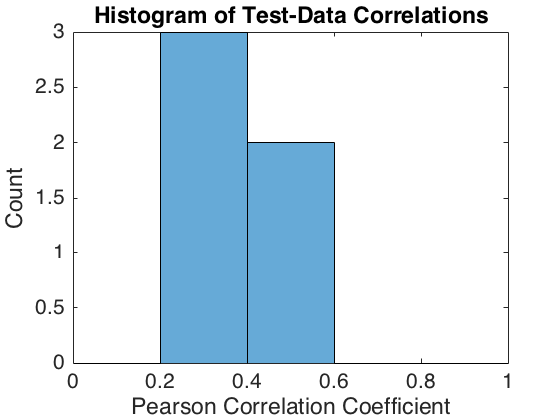

OASIS mean correlation on test data: 0.41


In [9]:
% run the test data
cd('~/Documents/Current-Projects/OASIS_matlab/');
W = 5;kernel = ones(W,1)./W;
correlations = zeros(length(test),1);

count = 1;
for ii=test
   calcium_train = allData{ii,1};
   spike_train = allData{ii,2};
   
   tempCorr = zeros(numNeurons(ii),1);
   for jj=1:numNeurons(ii)
      [~,est_s,~] = deconvolveCa(calcium_train(:,jj),'ar1','foopsi');
          
          
      % bin the data, calculate the correlation coefficient between estimated and true spike trains
      est_s = conv(est_s,kernel);
      
      true_s = spike_train(:,jj);
      true_s = conv(true_s,kernel);
          
      [r,~] = corrcoef(true_s,est_s);
      tempCorr(jj) = r(1,2);
    end
   correlations(count) = mean(tempCorr,1);
   count = count+1;
end

figure();histogram(correlations,0:0.2:1);
title('Histogram of Test-Data Correlations');
xlabel('Pearson Correlation Coefficient');ylabel('Count');

fprintf('OASIS mean correlation on test data: %3.2f\n',mean(correlations));

We can see that the AR1-FOOPSI algorithm runs a bit better on the test data than it did on the training data. The mean correlation of 0.41 seems good, but it is difficult to say whether or not 0.41 is suitable without comparison to other algorithms. A quick check the other day revealed that taking the correlation between the raw fluorescence traces and the true spike trains gave values ranging from about 0.05 to 0.15. Therefore, performing the deconvolution using this algorithm does provide an estimator more similar to the true spike train than the raw trace itself.

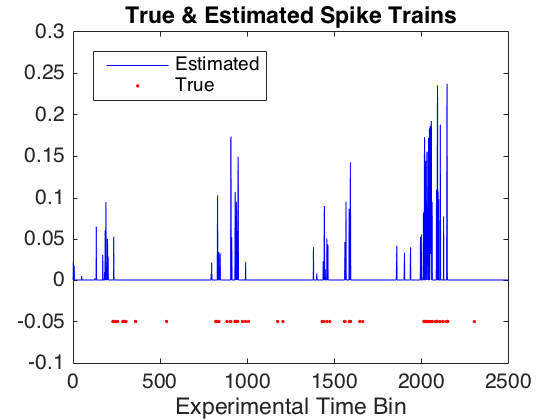

In [18]:
% Compare a true spike train to its estimated spike train
spike_train = allData{test(1),2};calcium_train = allData{test(1),1};
spike_train = spike_train(:,1);calcium_train = calcium_train(:,1);

[~,est_s,~] = deconvolveCa(calcium_train,'ar1','foopsi');

truetrain = spike_train(1:2500);
estimated = est_s(1:2500);

trueInds = find(truetrain==1);
truetrain = truetrain(trueInds)*-0.05;

figure();plot(1:2500,estimated,'b');hold on;
plot(trueInds,truetrain,'r.');
title('True & Estimated Spike Trains');
xlabel('Experimental Time Bin');
legend('Estimated','True','Location','Northwest');
axis([0 2500 -0.1 0.3]);

## Part 2) Custom Algorithm (Adapted from Jewell & Witten 2017)

Citation: Jewell & Witten, Exact Spike Train Inference via L0 Optimization, 2017 arXiv 

The algorithm that I create code for is described throughout the paper, but it is explicitly detailed in "Algorithm 2". It's comparable to the AR1-FOOPSI algorithm, but here we find arg-min 0.5(y-c)^2+lambdaXnorm(s,0). Whereas FOOPSI minimized over the 1-norm of the estimated spike train, s ... this algorithm minimizes over the 0-norm of s. They recast the model as a changepoint detection model and make use of algorithms developed for that purpose. Thus, the minimization is over the number of changepoints and the times at which they occur. This seems more suitable to the problem at hand than the algorithms described in the OASIS toolbox, which are forced to declare arbitrary thresholding if they want to get back to a spike train. It appears that the authors of the OASIS algorithms (Vogelstein, Paninski, Pnevmatikakis, etc.) were unaware that the L0 optimization problem had a computationally tractable solution. 
  
  
I'm going to write out the function below that runs the algorithm, but these Jupyter notebooks won't allow functions to be declared. So, the code below will call a version of the function that is already running on my computer. The algorithm has two free parameters: lambda and gamma (gama below, just to avoid overlapping with MATLAB's gamma function). The authors describe cross-validation techniques for evaluating these two parameters on any given dataset. Lambda is related to the neuron's firing rate, because as lambda gets bigger, the penalty for greater numbers of spikes becomes greater. Gamma is directly related to the decay constant of the calcium indicator as: gamma = 1-1/(tau X fs) ... where tau is the decay constant and fs is the sampling rate (X is a multiplication sign). Here, I'll use tau as a surrogate for gamma because of its interpretability.

One question that I have: is the L0 optimization equivalent to the original formulation from Vogelstein et al. 2010? In that paper, they propose a model with a Poisson prior on each bin of the spike train, s. They then argue that the optimization cannot be done with the Poisson prior and approximate with an exponential prior. The exponential prior yields an optimization problem equivalent to an L1 normalization. Is the Poisson prior equivalent to the L0 normalization in this case? If so, can we make a Gibbs sampler or an MCMC algorithm that runs the L0 optimization while automatically solving for the free parameters, lambda and gamma? Lambda and gamma would each get a prior based on empirical observations. Tau, for example, is known to be on the order 0.5 seconds, which yields an estimate of gamma for any given sampling rate.

### The L0 Algorithm as a MATLAB function

In [16]:
function [est_s] = L0_Algorithm(ca_trace,lambda,gama)
%L0_Algorithm.m
%  Runs the algorithm from Jewell & Witten 2017, calculating the spike times
%   for a given calcium fluorescence trace, and choice of lambda and gamma
%   gamma is equal to 1-1/(tau*Fs) ... where tau is the decay constant of
%   the calcium indicator and Fs is the sampling frequency in hertz
%
% The easiest way to make sense of this is to read the paper

N = length(ca_trace);
F = zeros(N+1,1);
est_s = zeros(N,1);

% 
changePoints = zeros(N,1);

% 
F(1) = -lambda;

F(2) = F(1)+CalcD(ca_trace(1),gama)+lambda;
changePoints(1) = 0;
epsilon = [1;2];
for ii=3:N+1
    %fprintf('%d\n',ii);
    
    set = zeros(length(epsilon),1);
    count = 1;
    for jj=epsilon'
        set(count) = F(jj)+CalcD(ca_trace(jj:ii-1),gama)+lambda;
        count = count+1;
    end
    [F(ii),ind] = min(set);
    changePoints(ii-1) = epsilon(ind);
    
    epsilon = [epsilon((set-lambda)<F(ii));ii];
end
changePoints = changePoints(changePoints~=0);
est_s(changePoints) = 1;

end

function [D_ab] = CalcD(y,gama)
% calculate D{y(a:b)} as in equation 8 from the paper
N = length(y);

C_ab_num = y(1);
C_ab_denom = 1;
for ii=2:N
    C_ab_num = C_ab_num+y(ii)*gama^(ii-1);
    C_ab_denom = C_ab_denom+gama^(2*(ii-1));
end

C_ab = C_ab_num/C_ab_denom;
D_ab1 = 0;D_ab2 = 0;D_ab3 = 0;
for ii=1:N
    D_ab1 = D_ab1+y(ii)^2/2;
    D_ab2 = D_ab2+y(ii)*gama^(ii-1);
    D_ab3 = D_ab3+gama^(2*(ii-1));
end

D_ab = D_ab1-C_ab*D_ab2+(C_ab^2/2)*D_ab3;

end



Error: Function definitions are not permitted in this context.


### First-pass of the algorithm on the training data

In [1]:
cd('~/Documents/Current-Projects/Nazer_NeuralData/spikefinder.train');

datasets = {'1','2','3','4','5','6','7','8','9','10'};
N = 10;
Fs = 100;

train = 1:5;test = 6:10;

allData = cell(N,2);
numNeurons = zeros(N,1);
for ii=1:10
   calcium_train = csvread([datasets{ii} '.train.calcium.csv']);
   spike_train = csvread([datasets{ii} '.train.spikes.csv']);  
   
   temp = quantile(calcium_train,[0.05,0.8]);

   calcium_train = (calcium_train-temp(1))./(temp(2)-temp(1));
   
   allData{ii,1} = calcium_train;
   allData{ii,2} = spike_train;
   numNeurons(ii) = size(calcium_train,2);
end

cd('~/Documents/Current-Projects/Nazer_NeuralData/');

W = 5;
kernel = ones(W,1)./W;
correlations = zeros(length(train),1);
runtime = zeros(length(train),1);

% test the algorithm out with simple starting values for lambda and gamma

numBins = 5000; % to reduce computational demand
tau = 1; % estimated decay constant for calcium imaging data
lambda = 1;gama = 1-1/(tau*Fs);
for ii=train
    calcium_train = allData{ii,1};
    spike_train = allData{ii,2};
    
%     stimLen = length(calcium_train);
%     bin_edges = 0:5:stimLen;
   
   tempCorr = zeros(numNeurons(ii),1);
   tempTimes = zeros(numNeurons(ii),1);
   for jj=1:numNeurons(ii)
      tic;
      [est_s] = L0_Algorithm(calcium_train(1:numBins,jj),lambda,gama);
      temptime = toc;tempTimes(jj) = temptime/numBins;
      est_s = conv(est_s,kernel);
      
      true_s = spike_train(1:numBins,jj);
      true_s = conv(true_s,kernel);
      
      [r,~] = corrcoef(true_s,est_s);
      tempCorr(jj) = r(1,2);
   end
   correlations(ii) = mean(tempCorr);
   runtime(ii) = mean(tempTimes);
end

fprintf('Run-time and correlation statistics for first-pass at L0 Optimzation Algorithm:\n\n');

fprintf('  Mean Per-Bin Run-Time: %3.2e\n  Mean Corr: %3.2f\n  Std Corr: %3.2f\n  Max Corr: %3.2f\n',mean(runtime),mean(correlations),std(correlations),max(correlations));

Run-time and correlation statistics for first-pass at L0 Optimzation Algorithm:

Mean Per-Bin Run-Time: 9.44e-03
  Mean Corr: 0.18
  Std Corr: 0.05
  Max Corr: 0.24


The first thing to note about this L0 algorithm is that it runs substantially slower than the algorithms in OASIS. This is partly due to the fact that I have not optimized the code. It is supposed to run in approximately O(T) time, where T is the number of time bins. However, I think it is safe to say that the algorithm presented in the Jewell & Witten paper is simpler than the ones in OASIS (it's only about 40 lines of code). Out of the box, we see that this algorithm works a bit worse than the other algorithms, though the sample size was much smaller, which may influence the results. The authors suggest some techniques for cross-validation to choose the parameters lambda and gamma, which I will try below.

### Varying the parameters lambda and tau 

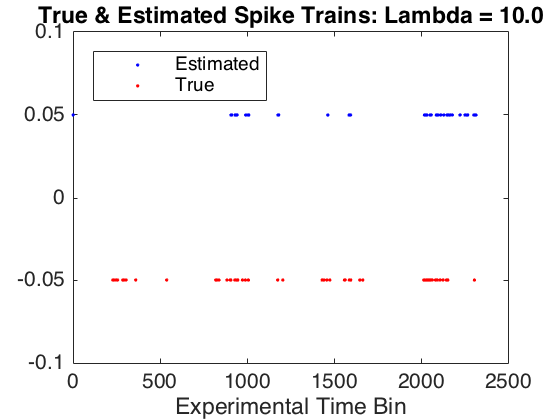

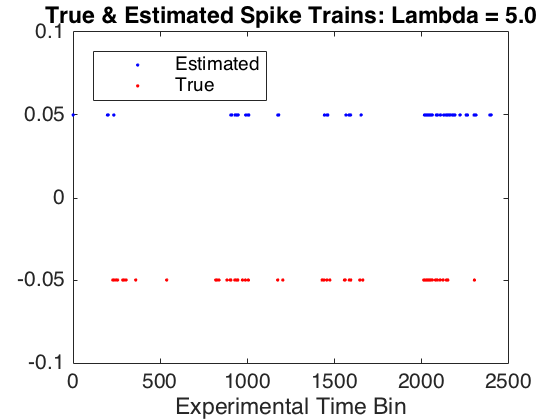

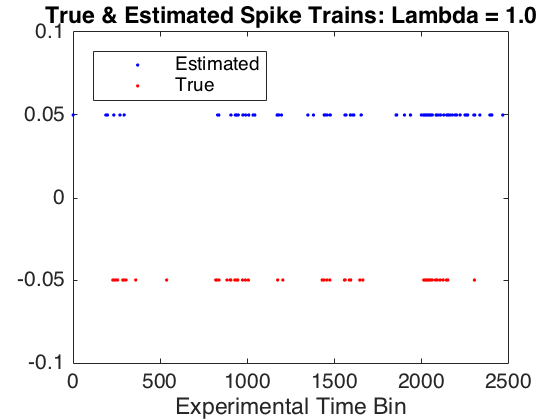

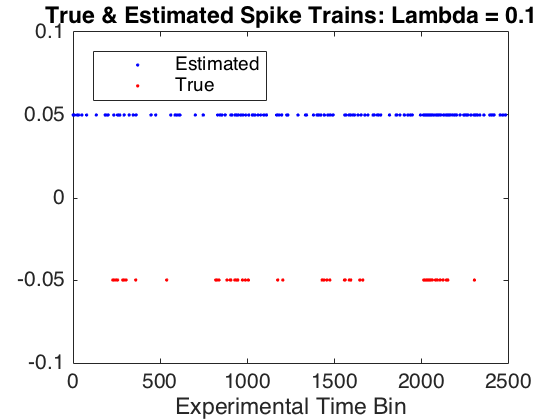

In [2]:
% Compare a true spike train to its estimated spike train for tau = 0.5
spike_train = allData{test(1),2};calcium_train = allData{test(1),1};
spike_train = spike_train(1:2500,1);calcium_train = calcium_train(1:2500,1);

tau = 0.5;Fs = 100;
gama = 1-1/(tau*Fs);
for lambda = [0.1,1,5,10]
    
    [est_s] = L0_Algorithm(calcium_train,lambda,gama);

    truetrain = spike_train;
    estimatedInds = find(est_s==1);
    estimated = est_s(estimatedInds)*0.05;

    trueInds = find(truetrain==1);
    truetrain = truetrain(trueInds)*-0.05;

    figure();plot(estimatedInds,estimated,'b.');hold on;
    plot(trueInds,truetrain,'r.');
    title(sprintf('True & Estimated Spike Trains: Lambda = %3.1f',lambda));
    xlabel('Experimental Time Bin');
    legend('Estimated','True','Location','Northwest');
    axis([0 2500 -0.1 0.1]);
end

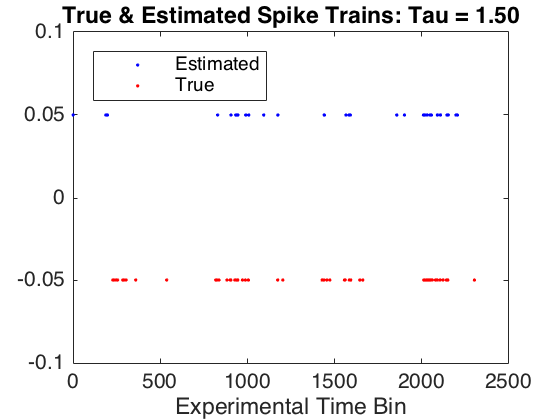

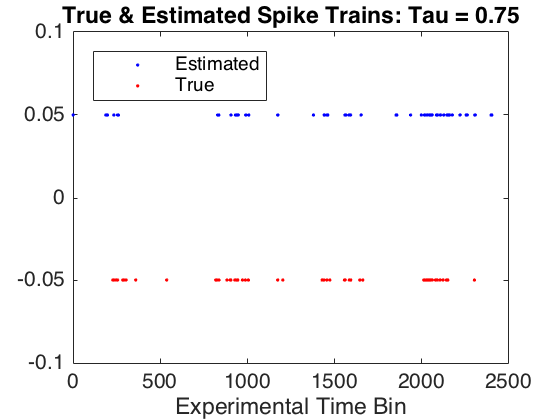

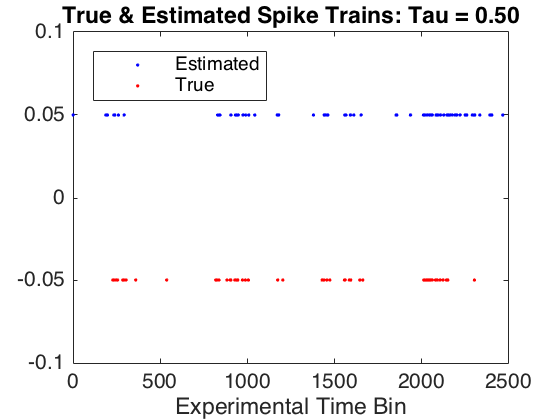

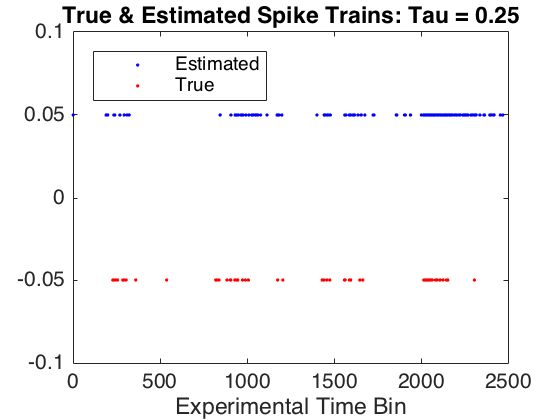

In [3]:
% Compare a true spike train to its estimated spike train for lambda = 1.5
spike_train = allData{test(1),2};calcium_train = allData{test(1),1};
spike_train = spike_train(1:2500,1);calcium_train = calcium_train(1:2500,1);

Fs = 100;
lambda = 1.5;
for tau = [0.25,0.5,0.75,1.5]
    gama = 1-1/(tau*Fs);
    [est_s] = L0_Algorithm(calcium_train,lambda,gama);

    truetrain = spike_train;
    estimatedInds = find(est_s==1);
    estimated = est_s(estimatedInds)*0.05;

    trueInds = find(truetrain==1);
    truetrain = truetrain(trueInds)*-0.05;

    figure();plot(estimatedInds,estimated,'b.');hold on;
    plot(trueInds,truetrain,'r.');
    title(sprintf('True & Estimated Spike Trains: Tau = %3.2f',tau));
    xlabel('Experimental Time Bin');
    legend('Estimated','True','Location','Northwest');
    axis([0 2500 -0.1 0.1]);
end

Clearly, both tau (through its effect on gamma) and lambda have a significant effect on the output of the algorithm. I'll do a simple grid search over lambda and tau to see how well we can do on this mini dataset in terms of correlation.

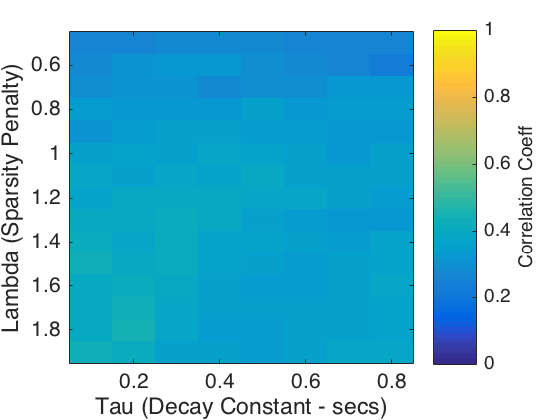

In [5]:
spike_train = allData{test(1),2};calcium_train = allData{test(1),1};
spike_train = spike_train(1:2500,1);calcium_train = calcium_train(1:2500,1);

W = 5;
kernel = ones(W,1)./W;

taus = 0.1:0.05:0.8;
lambdas = 0.5:0.2:2;

correlations = zeros(length(taus),length(lambdas));
for ii=1:length(taus)
   for jj=1:length(lambdas)
      gama = 1-1/(taus(ii)*Fs);
      [est_s] = L0_Algorithm(calcium_train,lambdas(jj),gama);
      
      true_s = conv(spike_train,kernel);
      est_s = conv(est_s,kernel);
      [r,~] = corrcoef(true_s,est_s);
      correlations(ii,jj) = r(1,2);
   end
end

figure();imagesc(taus,lambdas,correlations);
h = colorbar;
h.Label.String = 'Correlation Coeff';
caxis([0 1]);
h.Limits = [0,1];
xlabel('Tau (Decay Constant - secs)');
ylabel('Lambda (Sparsity Penalty)');

The best we did with this grid spacing is about 0.5, which is close to the best runs for the OASIS algorithm. I suspect that we could do even better using the more sophisticated cross-validation scheme described in Algorithm 3 of the paper. Due to time, I'm just going to run the test data on values for lambda and tau that worked well for this dataset: lambda=1.8, tau=0.2 . I'm sure this is a rough approximation.

### L0 Algorithm on the Test Data

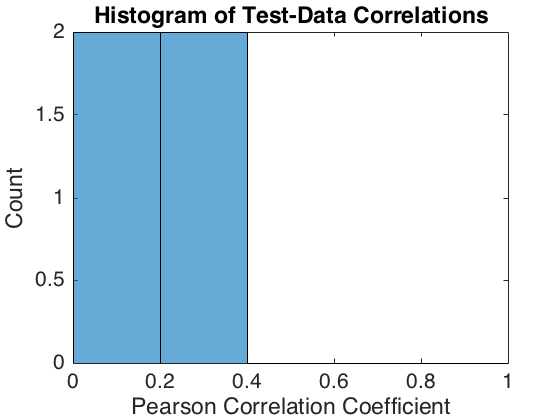

In [6]:
W = 5;kernel = ones(W,1)./W;
correlations = zeros(length(test),1);
lambda = 1.8;tau = 0.2;gama = 1-1/(tau*Fs);
count = 1;
numBins = 10000;
for ii=test
   calcium_train = allData{ii,1};
   spike_train = allData{ii,2};
   calcium_train = calcium_train(1:numBins,:);
   spike_train = spike_train(1:numBins,:);
   
   tempCorr = zeros(numNeurons(ii),1);
   for jj=1:numNeurons(ii)
      [est_s] = L0_Algorithm(calcium_train(:,jj),lambda,gama);
          
          
      % bin the data, calculate the correlation coefficient between estimated and true spike trains
      est_s = conv(est_s,kernel);
      
      true_s = conv(spike_train(:,jj),kernel);
          
      [r,~] = corrcoef(true_s,est_s);
      tempCorr(jj) = r(1,2);
    end
   correlations(count) = mean(tempCorr);
   count = count+1;
end

figure();histogram(correlations,0:0.2:1);
title('Histogram of Test-Data Correlations');
xlabel('Pearson Correlation Coefficient');ylabel('Count');

This result, while not terrible, suggests that it's best to use this algorithm while optimizing the parameters. One important point is that the L0 algorithm returns actual spike times, rather than the continuous output of the OASIS algorithms. I'll have to delve more closely into the parameter optimization problem to see if the L0 algorithm can outperform OASIS.